In [1]:
import numpy as np  
from matplotlib import pyplot as plt 
from PIL import Image    
import torch

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
import torchvision

import torch.nn.functional as F



In [20]:
MODEL = "patchcore"
CONFIG_PATH = f"/home/students/tyang/anomalib/src/anomalib/models/{MODEL}/config.yaml"
with open(file=CONFIG_PATH, mode="r",encoding="utf-8") as f:
    print(f.read())
    
config = get_configurable_parameters(config_path=CONFIG_PATH)

dataset:
  name: airogs
  format: airogs
  path: /home/students/tyang/airogs
  task: classification # options: [classification, segmentation]
  category: 0
  number_of_samples: 900
  pre_selection: True
  train_batch_size: 32
  eval_batch_size: 32
  num_workers: 8
  image_size: 640 # dimensions to which images are resized (mandatory)
  center_crop:   # dimensions to which images are center-cropped after resizing (optional)
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.5 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.5 # fraction of train/test images held out for validation (usage depends on val_split_mode)
  tiling:
    apply: false
    tile_size: null
    stride: null

In [21]:
data_module = get_datamodule(config=config)
data_module.prepare_data() # check if the dataset is avaliable
data_module.setup()

i, train_data = next(enumerate(data_module.train_dataloader()))

In [4]:
print(train_data["image"].shape)
print(train_data["image"][0].shape)

torch.Size([32, 3, 640, 640])
torch.Size([3, 640, 640])


In [6]:
from anomalib.pre_processing.transforms import Denormalize
images = train_data["image"]
batch_size, channels, height, width = images.shape
de_imgs = []
for i in range(batch_size):
    img = images[i]
    de_img = Denormalize()(img)
    de_imgs.append(de_img)


/home/students/tyang/anomalib/src/anomalib/pre_processing/transforms/custom.py:25: UserWarning: Denormalize is no longer used and will be deprecated in v0.4.0
  warnings.warn("Denormalize is no longer used and will be deprecated in v0.4.0")


In [7]:
import torchvision.transforms.functional as TF

invTrans = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0., 0., 0. ],
                                                                            std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                            torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                                            std = [ 1., 1., 1. ]),
                                            torchvision.transforms.Resize((640,640)),
                                            
                                            ])


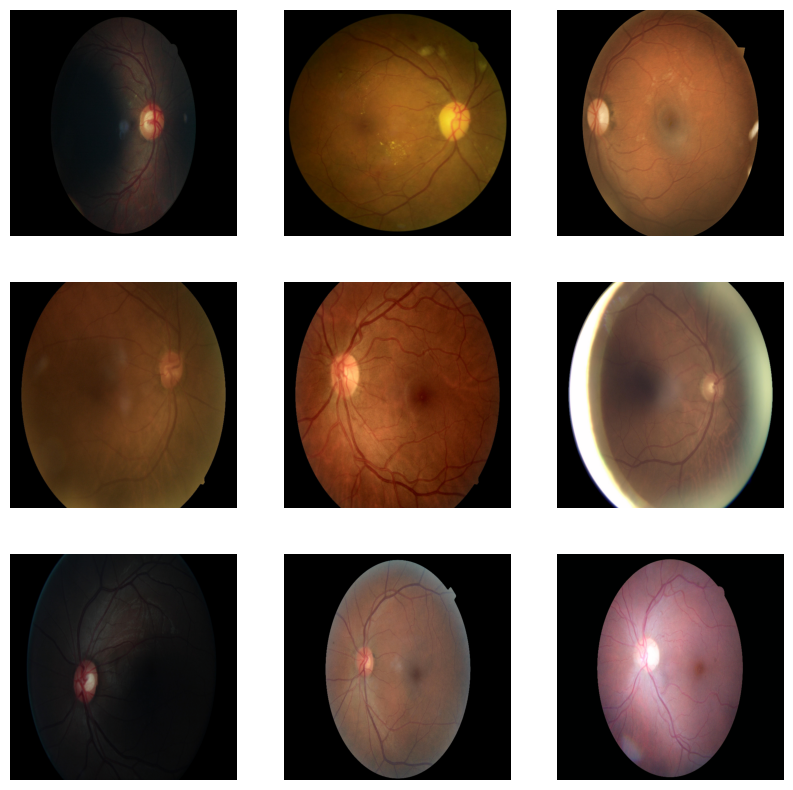

In [8]:

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    conv_img = invTrans(train_data["image"][i])
    plt.imshow(TF.to_pil_image(conv_img.squeeze()))
    plt.axis('off')

In [9]:
yolo_model_path = "/home/students/tyang/yolov5/runs/train/exp27/weights/best.pt"
yolo_model = torch.hub.load('/home/students/tyang/yolov5', 'custom', path=yolo_model_path, source='local')  

YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.13 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11171MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86173414 parameters, 0 gradients, 203.8 GFLOPs
Adding AutoShape... 


In [10]:
yolo_model.conf = 0.95
yolo_model.iou = 0.45
de_preds = yolo_model(de_imgs, size=640)

In [11]:
print(de_preds)

image 1/32: 640x640 1 optic disk
image 2/32: 640x640 1 optic disk
image 3/32: 640x640 1 optic disk
image 4/32: 640x640 1 optic disk
image 5/32: 640x640 1 optic disk
image 6/32: 640x640 1 optic disk
image 7/32: 640x640 1 optic disk
image 8/32: 640x640 1 optic disk
image 9/32: 640x640 1 optic disk
image 10/32: 640x640 1 optic disk
image 11/32: 640x640 1 optic disk
image 12/32: 640x640 1 optic disk
image 13/32: 640x640 1 optic disk
image 14/32: 640x640 1 optic disk
image 15/32: 640x640 1 optic disk
image 16/32: 640x640 1 optic disk
image 17/32: 640x640 1 optic disk
image 18/32: 640x640 1 optic disk
image 19/32: 640x640 1 optic disk
image 20/32: 640x640 1 optic disk
image 21/32: 640x640 1 optic disk
image 22/32: 640x640 1 optic disk
image 23/32: 640x640 1 optic disk
image 24/32: 640x640 1 optic disk
image 25/32: 640x640 1 optic disk
image 26/32: 640x640 1 optic disk
image 27/32: 640x640 1 optic disk
image 28/32: 640x640 1 optic disk
image 29/32: 640x640 1 optic disk
image 30/32: 640x640 1 

In [12]:
cropped_images = []
for i in range(batch_size):
     
      pred_t = de_preds.xyxy[i][0]
    
      x1, y1, x2, y2, conf, cls = pred_t
    
      x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
      cropped_image = train_data["image"][i][:, y1:y2, x1:x2]
    
      cropped_image = torchvision.transforms.Resize((240,240))(cropped_image)
      cropped_images.append(cropped_image)

cropped_images = torch.stack(cropped_images)

In [13]:
print(cropped_images.shape)

torch.Size([32, 3, 240, 240])


In [14]:
images = train_data["image"]
batch_size, channels, height, width = images.shape
tf_imgs = []
for i in range(batch_size):
    img = images[i]
    inv_img = invTrans(img)
    tf_img = TF.to_pil_image(inv_img.squeeze())
    tf_imgs.append(tf_img)
    

In [15]:

tf_preds = yolo_model(tf_imgs, size=640)

In [16]:
cropped_images = []
for i in range(batch_size):
     if tf_preds.xyxy[i].numel() == 0:
         continue
     else:
      pred_t = tf_preds.xyxy[i][0]
    
      x1, y1, x2, y2, conf, cls = pred_t
    
      x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
      cropped_image = train_data["image"][i][:, y1:y2, x1:x2]
    
      cropped_image = torchvision.transforms.Resize((240,240))(cropped_image)
      cropped_images.append(cropped_image)

cropped_images = torch.stack(cropped_images)

In [17]:
print(cropped_images.shape)

torch.Size([32, 3, 240, 240])


In [16]:
images = train_data["image"]
batch_size, channels, height, width = images.shape

cropped_images = []

for i in range(batch_size):
     if nms_pred[i].numel() == 0:
         continue
     else:
      pred_t = nms_pred[i].permute(1,0)
    
      x1, y1, x2, y2, conf, cls = pred_t
    
      x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
      cropped_image = train_data["image"][i][:, y1:y2, x1:x2]
    
      cropped_image = torchvision.transforms.Resize((240,240))(cropped_image)
      cropped_images.append(cropped_image)

cropped_images = torch.stack(cropped_images)

NameError: name 'nms_pred' is not defined

In [ ]:
#certain problems with tensor as inference input
from utils.general import non_max_suppression
images = train_data["image"]
pred = yolo_model(images)
print(pred.shape)
nms_pred = non_max_suppression(pred, conf_thres=0.6, iou_thres=0.45,)
print(len(nms_pred))

for i in range(len(nms_pred)):
    print(nms_pred[i].shape)
print(nms_pred[2])


In [ ]:
yolo_model.conf = 0.95

images = train_data["image"]

jpg_preds = []
for i in range(len(images)):
    img = images[i]
    img = (img * 255).to(torch.uint8)
    img_jpg = torchvision.io.encode_jpeg(img)
    im = Image.open(img_jpg)

    jpg_pred = yolo_model(im)
    jpg_preds.append(jpg_pred)


In [ ]:
yolo_model.conf = 0.95

images = train_data["image"]
print(images.shape)

np_preds = []
for i in range(len(images)):
    img = images[i]
    img_t = torch.permute(img, (1,2,0))
    img_np = img_t.numpy()
    np_pred = yolo_model(img_np)
    np_preds.append(np_pred)


In [ ]:
print(np_preds)

In [ ]:
#certain problems with tensor as inference input

from torchvision import transforms  
yolo_model.conf = 0.95
images = train_data["image"]
pil_preds = []
for i in range(len(images)):
    image = transforms.ToPILImage()(images[i])
    pil_pred = yolo_model(image)
    pil_preds.append(pil_pred)
    

In [ ]:
print(pil_preds)
   

In [ ]:
import cv2
yolo_model.conf = 0.25
images = train_data["image"]
cv_preds = []
cropped_images = []
for i in range(len(images)):
    image_t = images[i].cpu().numpy()
    image_t = np.transpose(image_t, (1,2,0))
    image_t = (image_t * 255).astype(np.uint8)
    opencv_image = cv2.cvtColor(image_t, cv2.COLOR_RGB2BGR) 
    cv_pred = yolo_model(opencv_image)
    cv_preds.append(cv_pred)
    
    

In [ ]:
for i in range(len(np_preds)):
    print(np_preds[i])


In [ ]:
#certain problems with tensor as inference input
from utils.general import non_max_suppression
images = train_data["image"]
pred = yolo_model(images)
print(pred.shape)
nms_pred = non_max_suppression(pred, conf_thres=0.6, iou_thres=0.45,)
print(len(nms_pred))

for i in range(len(nms_pred)):
    print(nms_pred[i].shape)
print(nms_pred[2])


In [ ]:
batch_size, channels, height, width = images.shape

cropped_images = []

for i in range(batch_size):
     if nms_pred[i].numel() == 0:
         continue
     else:
      pred_t = nms_pred[i].permute(1,0)
    
      x1, y1, x2, y2, conf, cls = pred_t
    
      x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
      cropped_image = train_data["image"][i][:, y1:y2, x1:x2]
    
      cropped_image = torchvision.transforms.Resize((240,240))(cropped_image)
      cropped_images.append(cropped_image)

cropped_images = torch.stack(cropped_images)
    

In [ ]:
gray = torchvision.transforms.Grayscale(num_output_channels=1)(cropped_images)
print(gray.shape)
plt.imshow(gray[3].squeeze(), cmap="gray")